In [10]:
import sys
sys.path.append(r'/hr-fs02/hr_projekte/Pol-InSAR_InfoRetrieval/10_users/mans_is/PyPolSAR')

In [11]:
import rioxarray
import rasterio as rio
import pandas as pd
import numpy as np
import xarray as xr
import geopandas as gpd
from shapely.geometry import box, mapping
from scipy import ndimage
from pypolsar import geo
import pprint


In [1]:
import h5py

from pypolsar import polsar
import matplotlib.pyplot as plt

from pypolsar import utils, plot
from pypolsar import polsar
from pypolsar.polsar import decomposition

from pypolsar.stats.timer import Timer
from pathlib import Path
import pypolsar

import seaborn as sns
import matplotlib
from matplotlib.colors import LogNorm
from matplotlib.ticker import PercentFormatter
import numpy as np
import matplotlib.patches as mpatches
from matplotlib.colors import ListedColormap


In [2]:
fig_save = Path("./../figures/")

In [22]:
from pathlib import Path

process_path = Path('./../data/01_projects/')

dem_dict = {}
dem_dict["18"] = sorted(list(process_path.glob("./18PRMASR/**/GTC/GTC-DEM/demgeo_18prmasr03*.rat")))

dem_dict["19"] = sorted(list(process_path.glob("./19PRMASR/**/GTC/GTC-DEM/demgeo_19prmasr10*.rat")))
pprint.pprint(dem_dict)

nadirgeo_dict = {}

nadirgeo_dict["18"] = sorted(list(process_path.glob("./18PRMASR/**/T01X/GTC/**/nadirgeo_18prmasr03*.rat")))

nadirgeo_dict["19"] = sorted(list(process_path.glob("./19PRMASR/**/T01X/GTC/**/offnadirgeo_19prmasr10*.rat")))
pprint.pprint(nadirgeo_dict)

{'18': [PosixPath('../data/01_projects/18PRMASR/FL03/PS02/T01X/GTC/GTC-DEM/demgeo_18prmasr0302_18prmasr0302_X1122hh_t01X.rat'),
        PosixPath('../data/01_projects/18PRMASR/FL03/PS03/T01X/GTC/GTC-DEM/demgeo_18prmasr0303_18prmasr0303_X1122hh_t01X.rat'),
        PosixPath('../data/01_projects/18PRMASR/FL03/PS04/T01X/GTC/GTC-DEM/demgeo_18prmasr0304_18prmasr0304_X1122hh_t01X.rat'),
        PosixPath('../data/01_projects/18PRMASR/FL03/PS05/T01X/GTC/GTC-DEM/demgeo_18prmasr0305_18prmasr0305_X1122hh_t01X.rat'),
        PosixPath('../data/01_projects/18PRMASR/FL03/PS06/T01X/GTC/GTC-DEM/demgeo_18prmasr0306_18prmasr0306_X1122hh_t01X.rat'),
        PosixPath('../data/01_projects/18PRMASR/FL03/PS07/T01X/GTC/GTC-DEM/demgeo_18prmasr0307_18prmasr0307_X1122hh_t01X.rat'),
        PosixPath('../data/01_projects/18PRMASR/FL03/PS08/T01X/GTC/GTC-DEM/demgeo_18prmasr0308_18prmasr0308_X1122hh_t01X.rat')],
 '19': [PosixPath('../data/01_projects/19PRMASR/FL10/PS02/T01X/GTC/GTC-DEM/demgeo_19prmasr1002_19prmasr

In [31]:
list(nadirgeo_dict["18"][0].parent.glob("mask*X22_t01X.rat"))

[PosixPath('../data/01_projects/18PRMASR/FL03/PS02/T01X/GTC/GTC-IMG/maskgeo_18prmasr0302_X22_t01X.rat')]

In [32]:
list(nadirgeo_dict["19"][0].parent.glob("mask*.rat"))

[PosixPath('../data/01_projects/19PRMASR/FL10/PS02/T01X/GTC/GTC-IMG/maskgeo_19prmasr1002_X_t01X.rat')]

In [68]:
def clip_dem_with_shp(dem, shapefile, invert=False):
    geodf = gpd.read_file(shapefile)
    xds = rioxarray.open_rasterio(dem, masked=True, )
    clipped = xds.rio.clip(geodf.geometry.apply(mapping), geodf.crs, invert=invert)
    return clipped

def substract_dem(dem1, dem2):
    from rasterio.warp import reproject, Resampling
    dem1_match = dem1.rio.reproject_match(dem2, resampling=Resampling.bilinear)
    dem1_match.data[ dem1_match.data == np.nanmin(dem1_match.data)] = np.nan
    dem2.data[ dem2.data == np.nanmin(dem2.data)] = np.nan
    dem_diff = dem2 - dem1_match
    dem_diff.data[ dem_diff.data == np.nanmin(dem_diff.data)] = np.nan
    return dem_diff 

def process_aoi_rg_profile(main_raster, aoi_raster, shapefile, save_path):
    aoi_clip = clip_dem_with_shp(dem=aoi_raster, shapefile=shapefile, invert=True)
    aoi_clip.data[ aoi_clip.data == np.nanmin(aoi_clip.data)] = np.nan
    
    aoi_clip_match = aoi_clip.rio.reproject_match(main_raster)
    aoi_clip_match.data[ aoi_clip_match.data == np.nanmin(aoi_clip_match.data)] = np.nan
    aoi_clip_match

    aoi_clip_match_wgs = aoi_clip_match.rio.reproject("epsg:4326")
    aoi_clip_match_wgs.data[ aoi_clip_match_wgs.data == np.nanmin(aoi_clip_match_wgs.data)] = np.nan

    clip_dem_diff_wgs = main_raster.rio.reproject("epsg:4326")
    clip_dem_diff_wgs.data[ clip_dem_diff_wgs.data == np.nanmin(clip_dem_diff_wgs.data)] = np.nan
    
    sns.histplot(clip_dem_diff_wgs.data.flatten(), stat="density")
    dem_perc = np.nanpercentile(clip_dem_diff_wgs.data, [0.01, 99.99])
    plt.xlim(dem_perc[0], dem_perc[1])
    plt.xlabel("Dem Diff (2019 - 2018) [m]")
    plt.savefig(save_path + "_hist.png")
    plt.clf()
    
    g = sns.jointplot(x=np.rad2deg(np.nanmean(aoi_clip_match_wgs.data, axis=1).flatten()),  y=np.nanmean(clip_dem_diff_wgs.data, axis=1).flatten(), kind="reg",)
    plt.xlabel("Off-nadir [Deg]")
    plt.ylabel("Dem Diff (2019 - 2018) [m]")
    # plt.title("Colors vs Values")
    # plt.savefig(save_path + "_profile_rg.png")
    # plt.clf()


In [115]:
def prepare_range_profile(x_rio, y_rio):
    
    from rasterio.warp import reproject, Resampling

    # x_rio_rep = x_rio.rio.reproject_match(y_rio, resampling=Resampling.bilinear)
    x_rio_wgs = x_rio.rio.reproject("epsg:4326", resampling=Resampling.bilinear)
    y_rio_wgs = y_rio.rio.reproject("epsg:4326", resampling=Resampling.bilinear)
    x_rio_wgs.data[ x_rio_wgs.data == np.nanmin(x_rio_wgs.data)] = np.nan
    y_rio_wgs.data[ y_rio_wgs.data == np.nanmin(y_rio_wgs.data)] = np.nan
    
    return x_rio_wgs, y_rio_wgs


def get_overlap_difference(raster_1_path, raster_2_path):
    raster_n0 = pypolsar.io.rat.geo_rat.open_ratgeo(raster_1_path)
    raster_n1 = pypolsar.io.rat.geo_rat.open_ratgeo(raster_2_path)
    raster_overlap_diff = substract_dem(raster_n0, raster_n1)
    
    return raster_overlap_diff

def range_profile_x_y(x_rio_wgs, y_rio_wgs):

    x_profile = np.nanmean(x_rio_wgs.data, axis=1).flatten()
    y_profile = np.nanmean(y_rio_wgs.data, axis=1).flatten()
    
    return x_profile, y_profile

In [112]:
raster_y_overlap = get_overlap_difference(raster_1_path=dem_dict["18"][0], raster_2_path=dem_dict["18"][1])

In [116]:
x_rio = pypolsar.io.rat.geo_rat.open_ratgeo(nadirgeo_dict["18"][1])
x_rio_wgs, y_rio_wgs = prepare_range_profile(x_rio=x_rio, y_rio=raster_y_overlap)

x, y = range_profile_x_y(np.rad2deg(x_rio_wgs), y_rio_wgs)

<ipython-input-115-77ebb8123bc4>:23: RuntimeWarning: Mean of empty slice
  x_profile = np.nanmean(x_rio_wgs.data, axis=1).flatten()
<ipython-input-115-77ebb8123bc4>:24: RuntimeWarning: Mean of empty slice
  y_profile = np.nanmean(y_rio_wgs.data, axis=1).flatten()


Text(17.625, 0.5, 'Dem Diff (2019 - 2018) [m]')

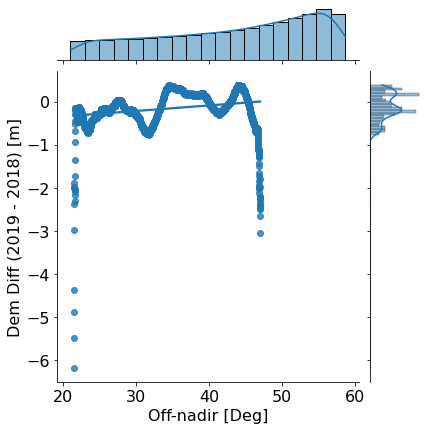

In [120]:

g = sns.jointplot(x=x,  y=y, kind="reg",)
plt.xlabel("Off-nadir [Deg]")
plt.ylabel("Dem Diff (2019 - 2018) [m]")

In [60]:
demgeo_19prmasr_n0 = pypolsar.io.rat.geo_rat.open_ratgeo(dem_dict["19"][0])
demgeo_19prmasr_n1 = pypolsar.io.rat.geo_rat.open_ratgeo(dem_dict["19"][1])

demgeo_18prmasr_n0 = pypolsar.io.rat.geo_rat.open_ratgeo(dem_dict["18"][0])
demgeo_18prmasr_n1 = pypolsar.io.rat.geo_rat.open_ratgeo(dem_dict["18"][1])


In [85]:
nadirgeo_18prmasr_n1 = pypolsar.io.rat.geo_rat.open_ratgeo(nadirgeo_dict["18"][1])
nadirgeo_18prmasr_n1

<xarray.DataArray (band: 1, y: 7340, x: 2760)>
array([[[nan, nan, ..., nan, nan],
        [nan, nan, ..., nan, nan],
        ...,
        [nan, nan, ..., nan, nan],
        [nan, nan, ..., nan, nan]]], dtype=float32)
Coordinates:
    wavelength   (band) float64 0.0309
  * band         (band) int64 1
  * y            (y) float64 7.728e+06 7.728e+06 ... 7.714e+06 7.714e+06
  * x            (x) float64 5.697e+05 5.697e+05 ... 5.752e+05 5.752e+05
    spatial_ref  int64 0
Attributes:
    scale_factor:         1.0
    add_offset:           0.0
    bands:                1
    byte_order:           0
    data_type:            4
    description:          Geocoded data /fsar_raid/18PRMASR/FL03/PS03/T01X/GT...
    file_type:            ENVI Standard
    georeferenced:        UTM
    header_offset:        1000
    interleave:           BIP
    lines:                7340
    max_easting:          575204.0000000000
    max_northing:         7728278.0000000000
    min_easting:          569686.0000000000
    min_northing:         7713600.0000000000
    pixel_spacing_east:   2.0000000000
    pixel_spacing_north:  2.0000000000
    projection_zone:      7
    samples:              2760
    sensor_type:          SAR
    spheroid_name:        WGS-84
    grid_mapping:         spatial_ref

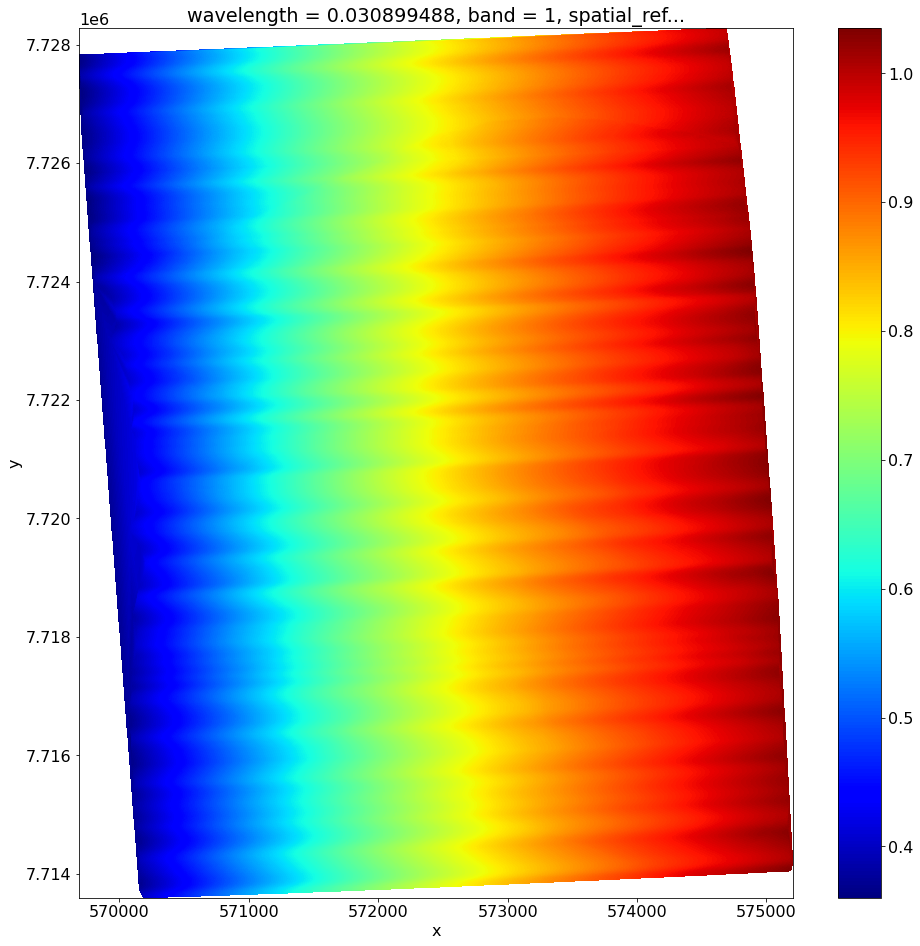

In [84]:
nadirgeo_18prmasr_n1.plot(cmap="jet")

In [76]:
nadirgeo_18prmasr_n1.rio.crs, 

CRS.from_epsg(32607)

In [69]:
dem_diff18 = substract_dem(demgeo_18prmasr_n0, demgeo_18prmasr_n1)

In [78]:
dem_diff18.rio.crs

CRS.from_epsg(32607)

In [88]:
from rasterio.warp import reproject, Resampling

nadirgeo_18prmasr_n1_rep = nadirgeo_18prmasr_n1.rio.reproject_match(demgeo_18prmasr_n1, resampling=Resampling.bilinear)

In [70]:
dem_diff18.data[ dem_diff18.data == np.nanmin(dem_diff18.data)] = np.nan

dem_diff18

<xarray.DataArray (band: 1, y: 7340, x: 2760)>
array([[[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]]], dtype=float32)
Coordinates:
    wavelength   (band) float64 0.0309
  * band         (band) int64 1
  * y            (y) float64 7.728e+06 7.728e+06 ... 7.714e+06 7.714e+06
  * x            (x) float64 5.697e+05 5.697e+05 ... 5.752e+05 5.752e+05
    spatial_ref  int64 0

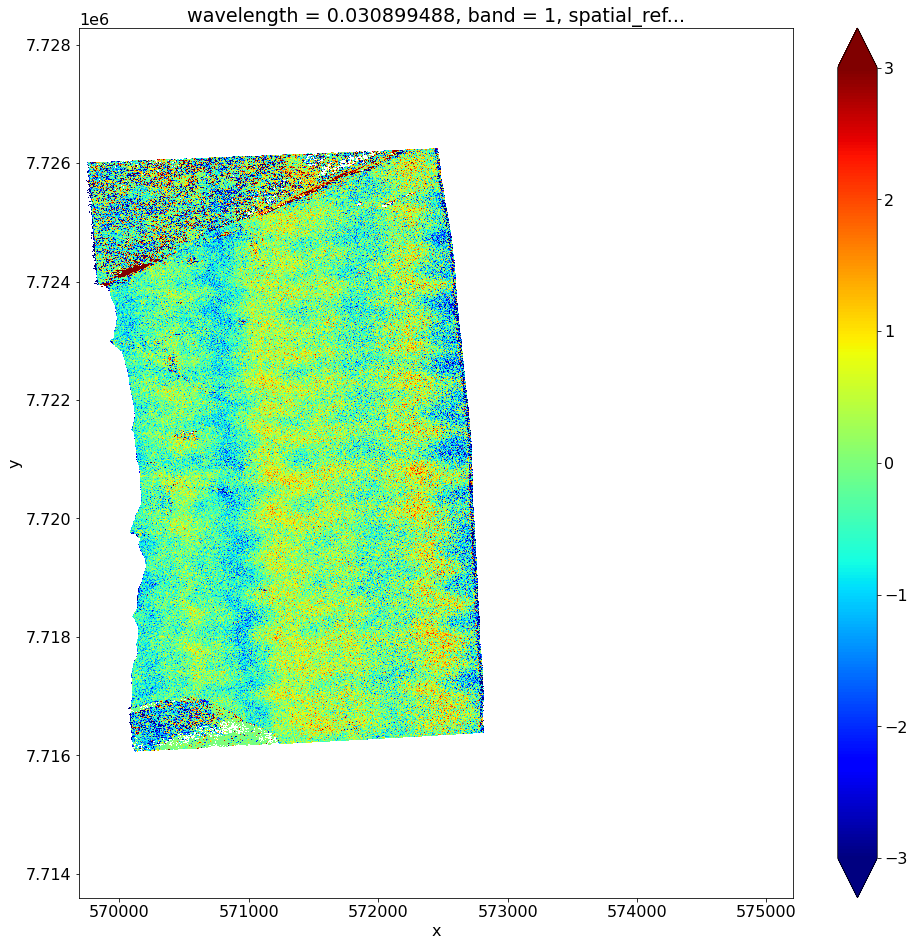

In [73]:
dem_diff18.plot(cmap="jet",vmin=-3, vmax=3)

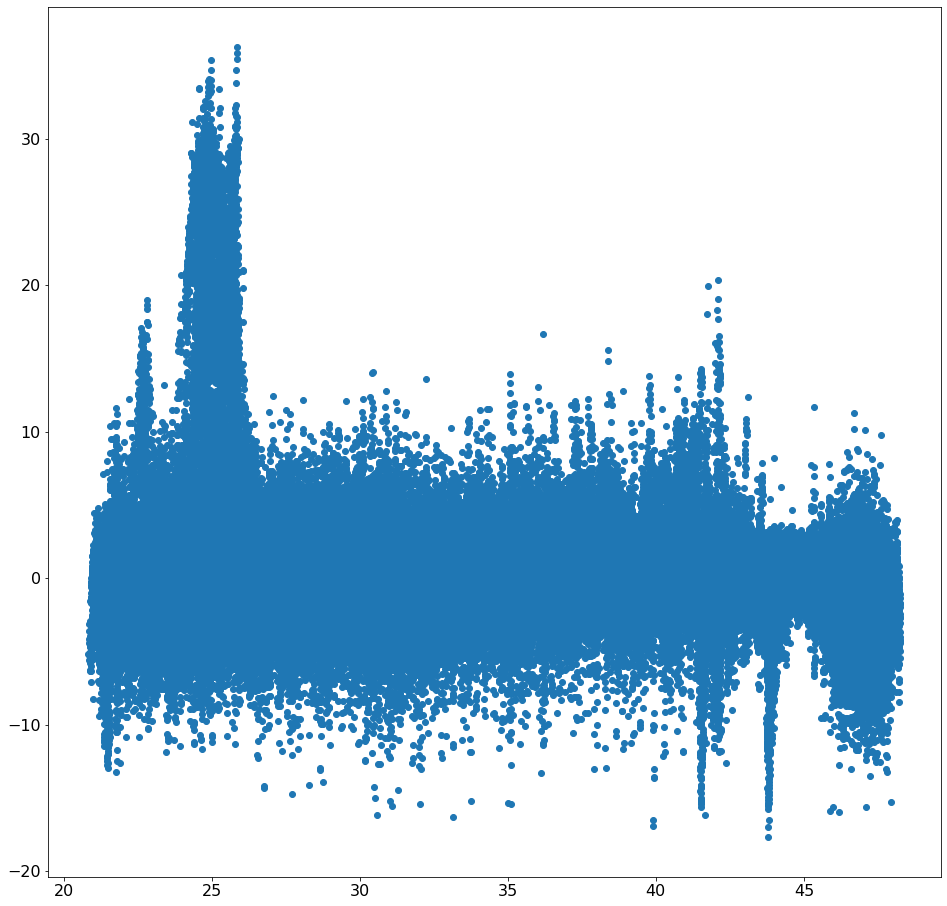

In [248]:
plt.scatter(np.rad2deg(x_rio_wgs.data.flatten()), y_rio_wgs.data.flatten())

In [121]:
import pandas as pd




df = pd.DataFrame({'x':x, 'y':y})
df = df.dropna()


from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(
    df.x.values.reshape(-1,1), df.y, test_size=0.33, random_state=42)

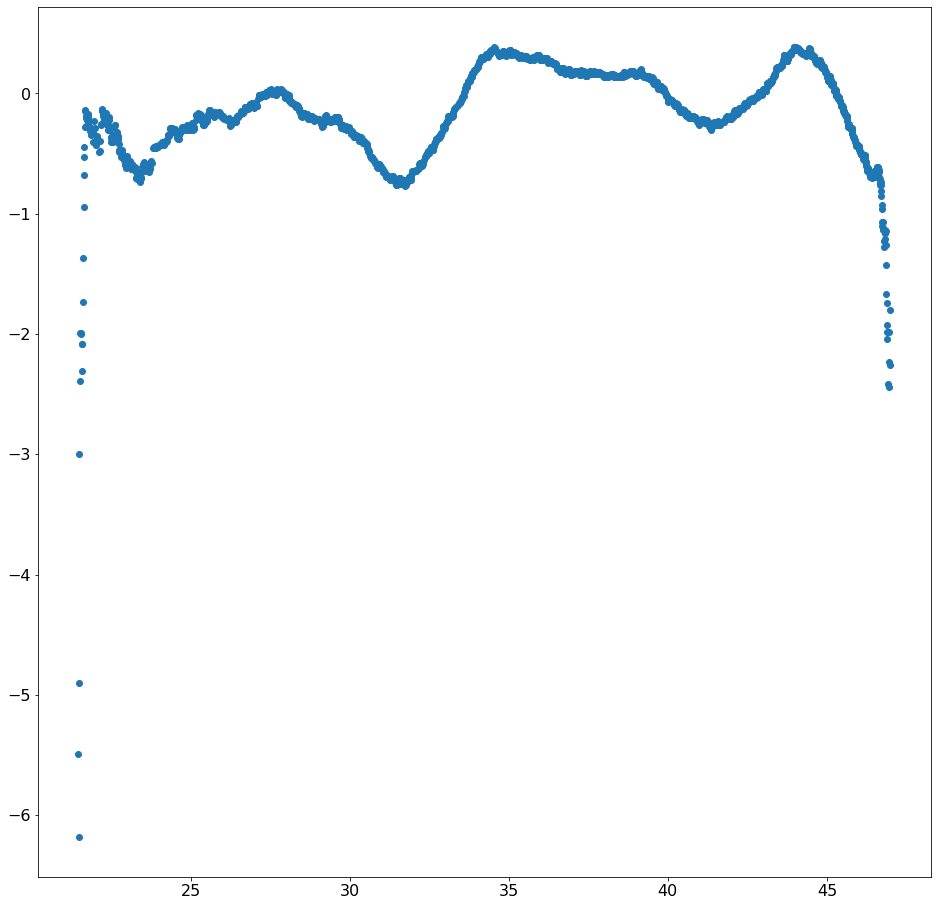

In [122]:
plt.scatter(X_train, y_train)

In [123]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
# Make predictions using the testing set

model = LinearRegression().fit(X_train, y_train)

Coefficients: 
 [0.01422113]
Mean squared error: 0.18
Coefficient of determination: 0.03


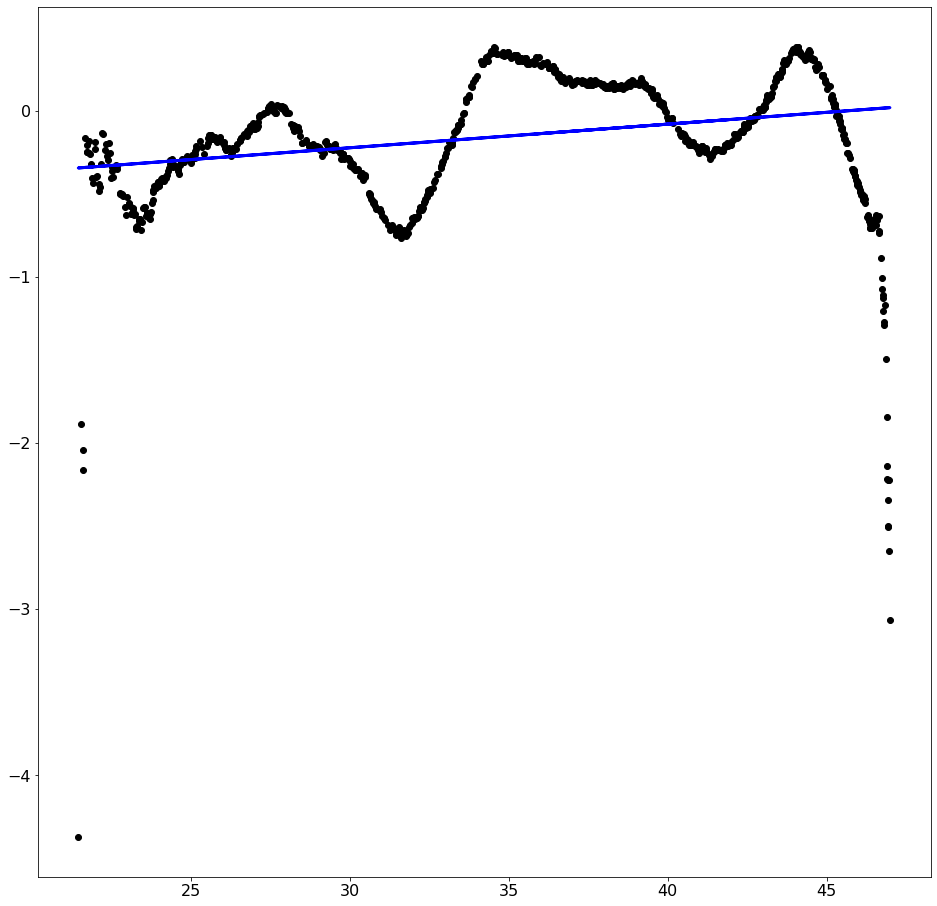

In [125]:
# Make predictions using the testing set
y_pred = model.predict(X_test)

# The coefficients
print('Coefficients: \n', model.coef_)
# The mean squared error
print('Mean squared error: %.2f'
      % mean_squared_error(y_test, y_pred))
# The coefficient of determination: 1 is perfect prediction
print('Coefficient of determination: %.2f'
      % r2_score(y_test, y_pred))

# Plot outputs
plt.scatter(X_test, y_test,  color='black')
plt.plot(X_test, y_pred, color='blue', linewidth=3)

#plt.xticks(())
#plt.yticks(())

plt.show()

In [221]:
def recreate_image(model, main_image_xr,):
    """Recreate the (compressed) image from the code book & labels"""
    x_rio_df = main_image_xr.to_dataframe(name="offnadir")
    x_rio_df_na = x_rio_df.reset_index().dropna()

    x_rio_df_na["y_error"] = model.predict(x_rio_df_na["offnadir"].values.reshape(-1, 1) )
    # y_rio_error_df = pd.DataFrame(model.predict(x_rio_df_na["offnadir"].values.reshape(-1, 1) ))
    x_rio_df_na_multi = x_rio_df_na.set_index(['band', 'y', 'x'])
    x_rio_df_org_y_error = x_rio_df.join(x_rio_df_na_multi["y_error"], )
    x_rio_y_error = x_rio_df_org_y_error.to_xarray()
    return x_rio_y_error



In [225]:
demgeo_n0 = pypolsar.io.rat.geo_rat.open_ratgeo(dem_dict["18"][0])
demgeo_n1 = pypolsar.io.rat.geo_rat.open_ratgeo(dem_dict["18"][1])
nadirgeo_n0 = pypolsar.io.rat.geo_rat.open_ratgeo(nadirgeo_dict["18"][0])
nadirgeo_n1 = pypolsar.io.rat.geo_rat.open_ratgeo(nadirgeo_dict["18"][1])
x_rio_y_error_0 = recreate_image(model=model, main_image_xr=nadirgeo_n0)
x_rio_y_error_1 = recreate_image(model=model, main_image_xr=nadirgeo_n1)


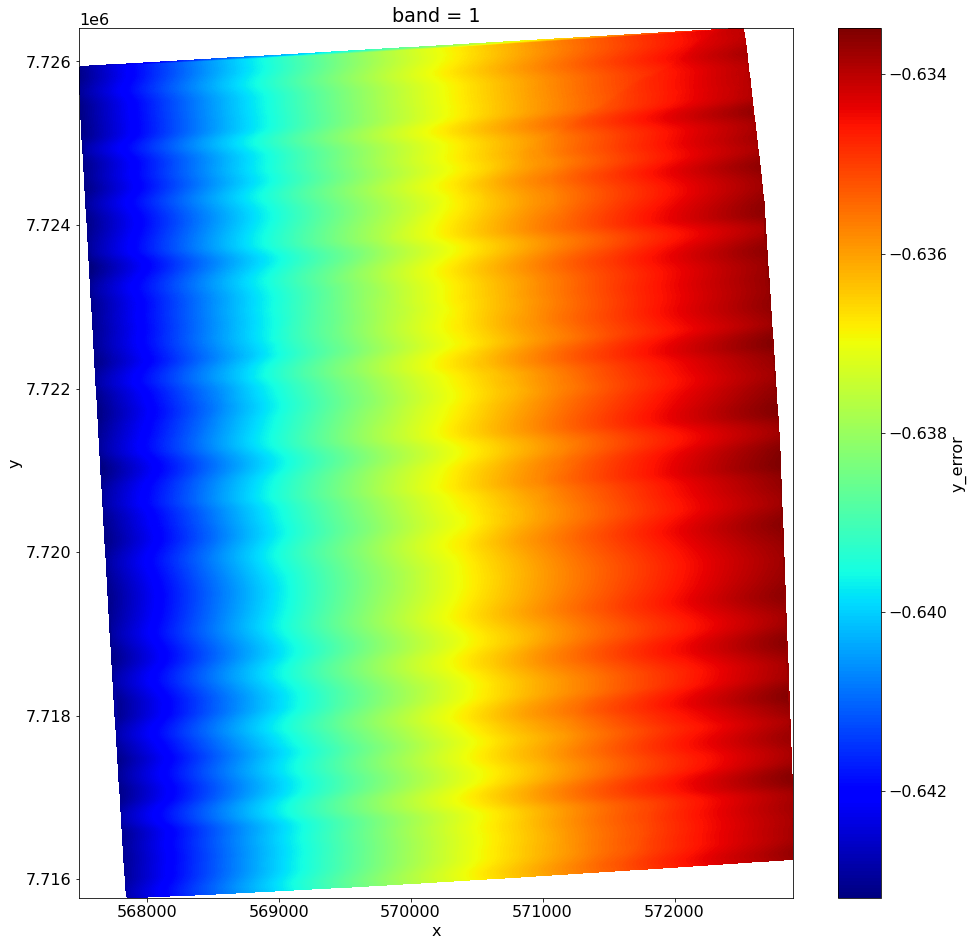

In [226]:
x_rio_y_error_0.y_error.plot(cmap="jet")

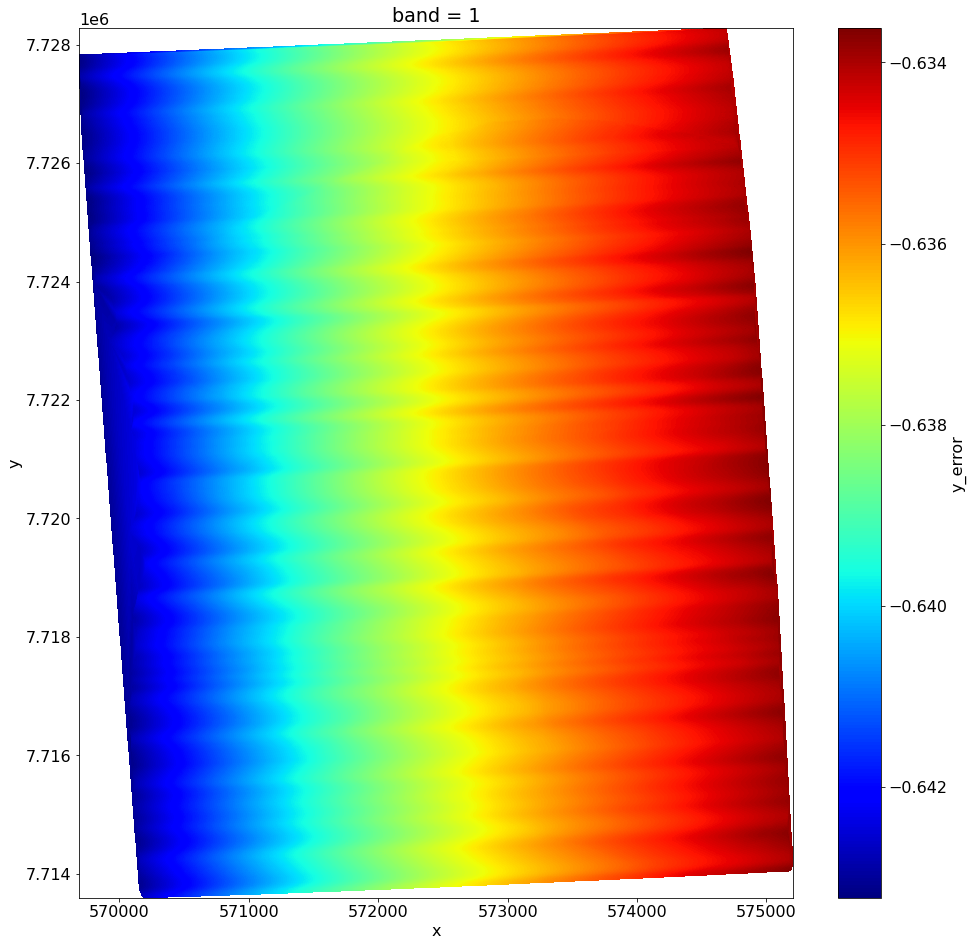

In [227]:
x_rio_y_error_1.y_error.plot(cmap="jet")

In [235]:
demgeo_n0_corrected = demgeo_n0 - x_rio_y_error_0.y_error
demgeo_n1_corrected = demgeo_n1 - x_rio_y_error_1.y_error

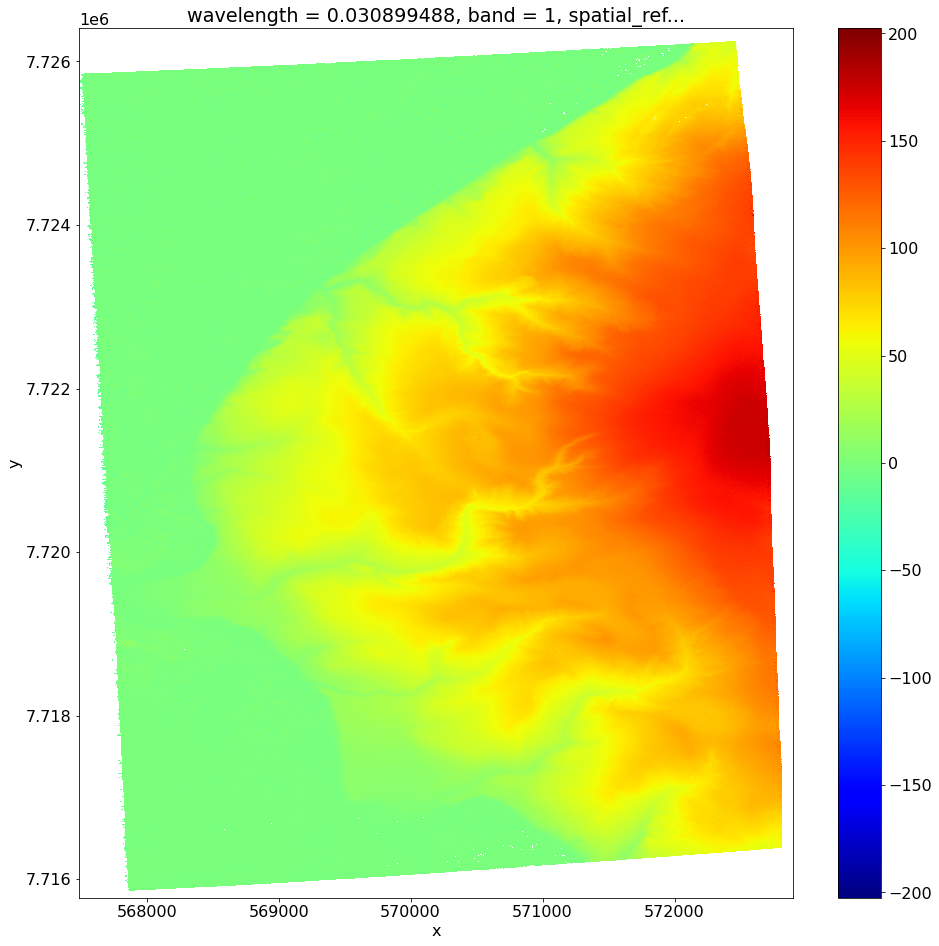

In [240]:
demgeo_n0_corrected.plot(cmap="jet")

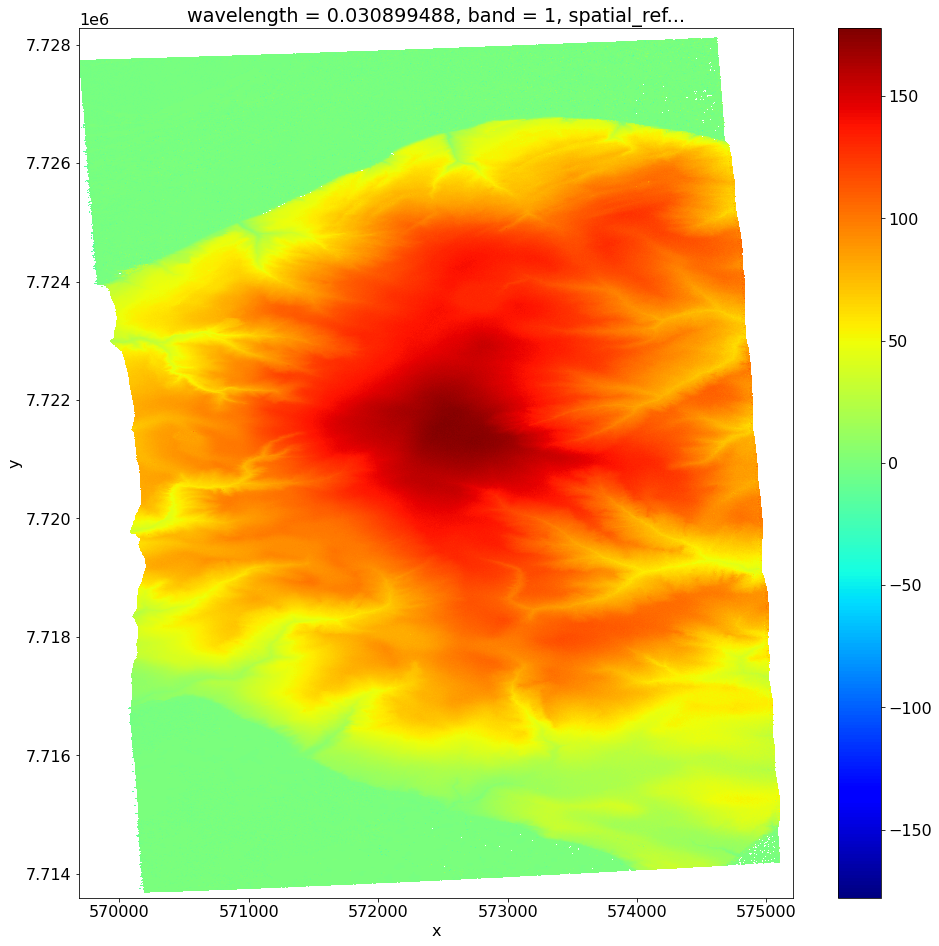

In [241]:
demgeo_n1_corrected.plot(cmap="jet")

In [243]:
raster_overlap_diff_corrected = substract_dem(demgeo_n0_corrected, demgeo_n1_corrected)

In [244]:
x_rio_corrected, y_rio_wgs_corrected = prepare_range_profile(x_rio=nadirgeo_n1, y_rio=raster_overlap_diff_corrected)

x_corrected, y_corrected= range_profile_x_y(np.rad2deg(x_rio_corrected), y_rio_wgs_corrected)

<ipython-input-115-77ebb8123bc4>:23: RuntimeWarning: Mean of empty slice
  x_profile = np.nanmean(x_rio_wgs.data, axis=1).flatten()
<ipython-input-115-77ebb8123bc4>:24: RuntimeWarning: Mean of empty slice
  y_profile = np.nanmean(y_rio_wgs.data, axis=1).flatten()


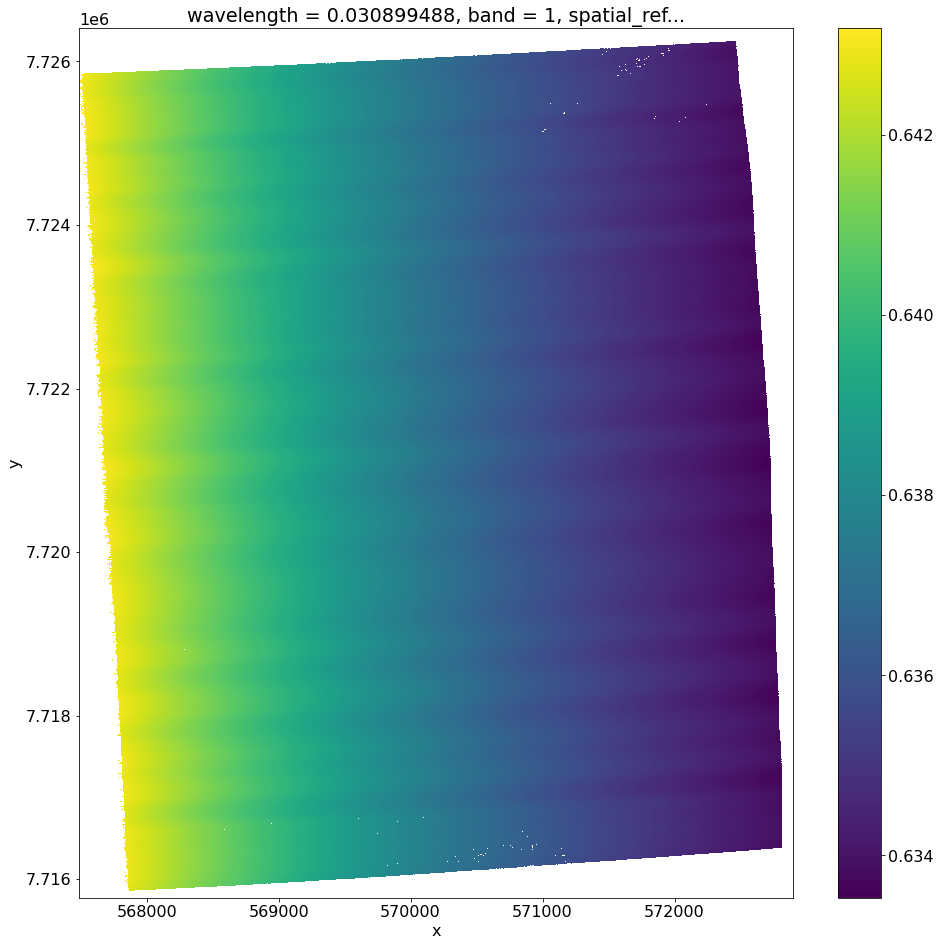

In [247]:
(demgeo_n0_corrected - demgeo_n0).plot()

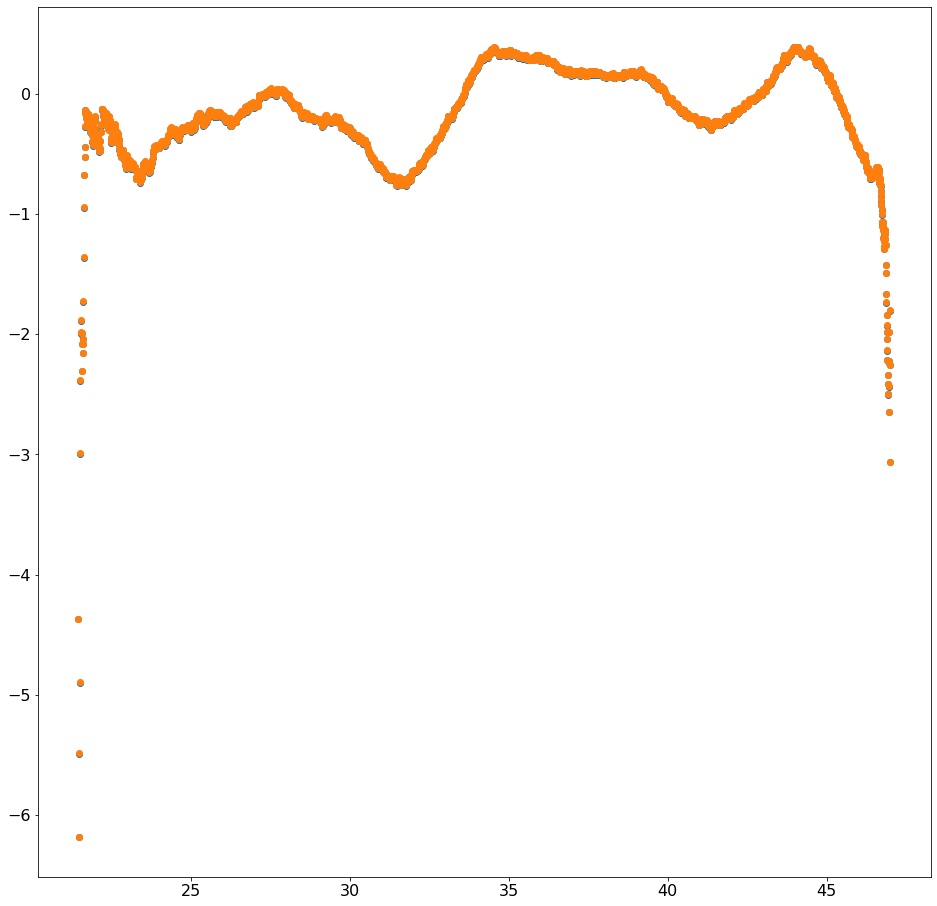

In [246]:
plt.scatter(x, y)
plt.scatter(x_corrected, y_corrected)

Text(17.625, 0.5, 'Dem Diff (18 n2 - 18 n1) [m]')

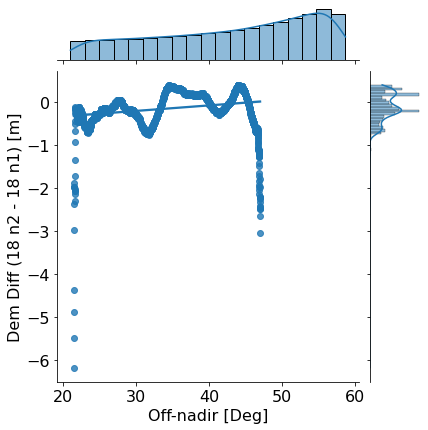

In [245]:

g = sns.jointplot(x=x_corrected,  y=y_corrected, kind="reg",)
plt.xlabel("Off-nadir [Deg]")
plt.ylabel("Dem Diff (18 n2 - 18 n1) [m]")

In [213]:
x_rio_wgs_df = x_rio_wgs.to_dataframe(name="offnadir")
x_rio_wgs_df_na = x_rio_wgs_df.reset_index().dropna()

x_rio_wgs_df_na["y_error"] = model.predict(x_rio_wgs_df_na["offnadir"].values.reshape(-1, 1) )
# y_rio_wgs_error_df = pd.DataFrame(model.predict(x_rio_wgs_df_na["offnadir"].values.reshape(-1, 1) ))
x_rio_wgs_df_na_multi = x_rio_wgs_df_na.set_index(['band', 'y', 'x'])
x_rio_wgs_df_org_y_error = x_rio_wgs_df_org.join(x_rio_wgs_df_na_multi["y_error"], )
x_rio_wgs_y_error = x_rio_wgs_df_org_y_error.to_xarray()

<ipython-input-213-345d680e0769>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_rio_wgs_df_na["y_error"] = model.predict(x_rio_wgs_df_na["offnadir"].values.reshape(-1, 1) )


In [214]:
x_rio_wgs_y_error

<xarray.Dataset>
Dimensions:      (band: 1, x: 6452, y: 5604)
Coordinates:
  * band         (band) int64 1
  * y            (y) float64 69.52 69.52 69.52 69.52 ... 69.65 69.65 69.65 69.65
  * x            (x) float64 -139.2 -139.2 -139.2 ... -139.1 -139.1 -139.1
Data variables:
    wavelength   (band, y, x) float64 0.0309 0.0309 0.0309 ... 0.0309 0.0309
    spatial_ref  (band, y, x) int64 0 0 0 0 0 0 0 0 0 0 ... 0 0 0 0 0 0 0 0 0 0
    offnadir     (band, y, x) float32 nan nan nan nan nan ... nan nan nan nan
    y_error      (band, y, x) float32 nan nan nan nan nan ... nan nan nan nan

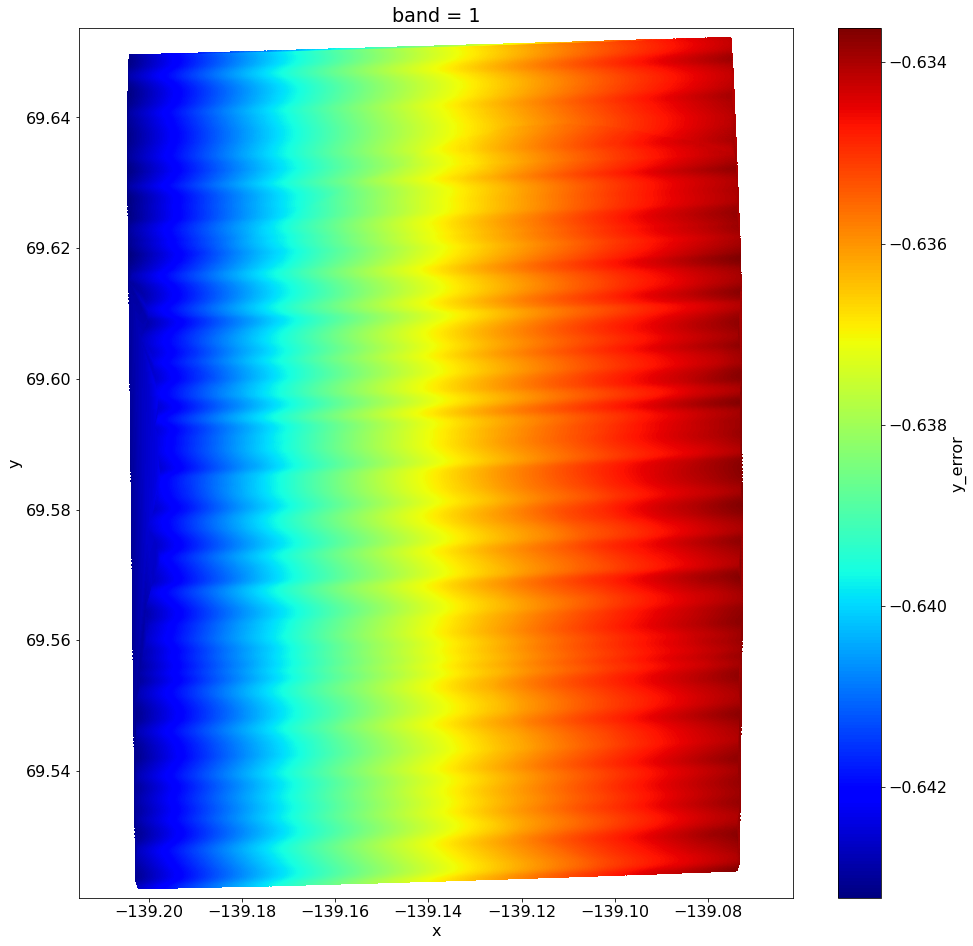

In [216]:
x_rio_wgs_y_error.y_error.plot(cmap="jet")

In [ ]:
plt.imshow(y_rio_wgs_error)

In [199]:
x_rio_wgs_df_na

,band,y,x,wavelength,spatial_ref,offnadir,y_error
392994,1,69.652249,-139.075471,0.030899,0,0.997408,-0.634158
392995,1,69.652249,-139.075447,0.030899,0,0.997462,-0.634157
392996,1,69.652249,-139.075424,0.030899,0,0.997543,-0.634156
392997,1,69.652249,-139.075400,0.030899,0,0.997639,-0.634154
392998,1,69.652249,-139.075376,0.030899,0,0.997716,-0.634153
...,...,...,...,...,...,...,...
35770460,1,69.522020,-139.201378,0.030899,0,0.407563,-0.642546
35770491,1,69.522020,-139.200642,0.030899,0,0.413208,-0.642466
35770492,1,69.522020,-139.200618,0.030899,0,0.413403,-0.642463
35770493,1,69.522020,-139.200594,0.030899,0,0.413622,-0.642460


In [202]:
x_rio_wgs_df_na_multi = x_rio_wgs_df_na.set_index(['band', 'y', 'x'])

In [207]:
x_rio_wgs_df_na_multi["y_error"]

band  y          x          
1     69.652249  -139.075471   -0.634158
                 -139.075447   -0.634157
                 -139.075424   -0.634156
                 -139.075400   -0.634154
                 -139.075376   -0.634153
                                  ...   
      69.522020  -139.201378   -0.642546
                 -139.200642   -0.642466
                 -139.200618   -0.642463
                 -139.200594   -0.642460
                 -139.200571   -0.642456
Name: y_error, Length: 29583814, dtype: float32

In [210]:
x_rio_wgs_df_org_y_error = x_rio_wgs_df_org.join(x_rio_wgs_df_na_multi["y_error"], )

In [212]:
x_rio_wgs_df_org_y_error.to_xarray()

<xarray.Dataset>
Dimensions:      (band: 1, x: 6452, y: 5604)
Coordinates:
  * band         (band) int64 1
  * y            (y) float64 69.52 69.52 69.52 69.52 ... 69.65 69.65 69.65 69.65
  * x            (x) float64 -139.2 -139.2 -139.2 ... -139.1 -139.1 -139.1
Data variables:
    wavelength   (band, y, x) float64 0.0309 0.0309 0.0309 ... 0.0309 0.0309
    spatial_ref  (band, y, x) int64 0 0 0 0 0 0 0 0 0 0 ... 0 0 0 0 0 0 0 0 0 0
    offnadir     (band, y, x) float32 nan nan nan nan nan ... nan nan nan nan
    y_error      (band, y, x) float32 nan nan nan nan nan ... nan nan nan nan

In [195]:
df1 = pd.DataFrame([['a', 'x', 0.471780], ['a','y', 0.774908], ['a', 'z', 0.563634],
                    ['b', 'x', -0.353756], ['b', 'y', 0.368062], ['b', 'z', -1.721840],
                    ['c', 'x', 1], ['c', 'y', 2], ['c', 'z', 3],
                   ],
                   columns=['first', 'second', 'value1']
                   ).set_index(['first', 'second'])
df2 = pd.DataFrame([['a', 10], ['b', 20]],
                   columns=['first', 'value2']).set_index(['first'])

print(df1.join(df2, how='inner'))

                value1  value2
first second                  
a     x       0.471780      10
      y       0.774908      10
      z       0.563634      10
b     x      -0.353756      20
      y       0.368062      20
      z      -1.721840      20


In [ ]:
df1

In [197]:
df2

,value2
first,
a,10
b,20
